In [ ]:
!pip install ml_metrics
!pip install deslib
!pip install faiss-cpu --no-cache
!pip install tqdm

/bin/bash: pip: command not found
/bin/bash: pip: command not found
/bin/bash: pip: command not found
/bin/bash: pip: command not found
/bin/bash: pip: command not found
/bin/bash: pip: command not found


# Imports

In [ ]:
# standard 
import faiss
import random
import numpy as np
import pandas as pd
import sklearn as sk
import xgboost as xgb
import seaborn as sb
from tqdm import tqdm, notebook
import datetime
from matplotlib import pyplot as plt
%matplotlib inline
# data processing
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# loss metric
from ml_metrics import mapk
from sklearn.metrics import f1_score, accuracy_score
# ensemble methods
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
# sklearn cross-validation
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
# individual models
from sklearn.svm import SVC, LinearSVC, LinearSVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from deslib.util.faiss_knn_wrapper import FaissKNNClassifier

In [ ]:
# for local usage
root_path = ''

In [ ]:
# Data
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/CIS_520/Final Project/'

# Data

## Data Loading

In [ ]:
# Global vars
rstate = 0
p = 0.01
v = 10

In [ ]:
# on colab, use only load_data, leaky_load will run out of memory
# loads percentage of data from file
def load_data(percentage, filename='train.csv'):
  random.seed(rstate)
  if percentage == 1:
    df = pd.read_csv(root_path + filename, header = 0)
  else:
    df = pd.read_csv(root_path + filename, header = 0,
                          skiprows = lambda i: i > 0 and random.random() > percentage)
  df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
  df['srch_ci'] = pd.to_datetime(df['srch_ci'], errors='coerce')
  df['srch_co'] = pd.to_datetime(df['srch_co'], errors='coerce')
  df['date_time'].fillna(method='ffill', inplace=True)
  df['srch_ci'].fillna(method='ffill', inplace=True)
  df['srch_co'].fillna(method='ffill', inplace=True)
  return df

# prioritizes getting all data for specific number of users 
def leaky_load(users, filename='train.csv'):
  df = load_data(1, filename)
  unique = df.user_id.unique().tolist()
  selected = random.sample(unique, min(users, len(unique)))
  return df[df.user_id.isin(selected)]

## Feature Selection Heuristic

In [ ]:
%%time
df = load_data(percentage=1)
df.head()

CPU times: user 43.3 s, sys: 3.87 s, total: 47.2 s
Wall time: 47.7 s


,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [ ]:
df.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')

In [ ]:
df.info()
len(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37623199 entries, 0 to 37670292
Data columns (total 24 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   date_time                  datetime64[ns]
 1   site_name                  int64         
 2   posa_continent             int64         
 3   user_location_country      int64         
 4   user_location_region       int64         
 5   user_location_city         int64         
 6   orig_destination_distance  float64       
 7   user_id                    int64         
 8   is_mobile                  int64         
 9   is_package                 int64         
 10  channel                    int64         
 11  srch_ci                    datetime64[ns]
 12  srch_co                    datetime64[ns]
 13  srch_adults_cnt            int64         
 14  srch_children_cnt          int64         
 15  srch_rm_cnt                int64         
 16  srch_destination_id        int64  

37623199

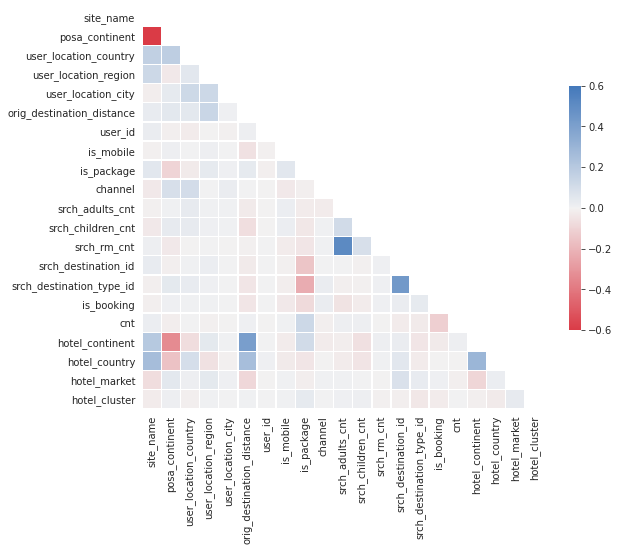

In [ ]:
# Correlation plotting
def plot_corr(data):
  corr = data.corr()
  mask = np.triu(np.ones_like(corr, dtype=np.bool))
  sb.set_style(style = 'white')

  f, ax = plt.subplots(figsize=(9, 9))
  cmap = sb.diverging_palette(10, 250, as_cmap=True)
  sb.heatmap(corr, mask=mask, cmap=cmap, 
          square=True, vmin=-.6, vmax=.6,
          linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

plot_corr(df)

As such, we observe that some features such as site_name and posa_continent, which is defined as the "ID of continent associated with site_name," are highly correlated with one another without being as correlated with our target variable, hotel_cluster, and could thus be removed for model training. We can remove both of these in favor of keeping hotel_continent. Similarly, it makes sense that srch_adults_cnt and srch_rm_cnt would be strongly correlated.
Additionally, we can also drop sessions that did not result in a booking, as we are only interested in predicting the ones that do. User behavior is likely to differ between seriously searching for a booking or, say, browsing for resorts in the maledives to distract themselves from their cold February in Philadelphia.
Other features we might consider dropping are user_id, for instance. New user_ids are constantly created and, by themselves, are equivalent to noise for our classifiers. Similarly with search_destination_id which, as well, is highly correlated by search_destination_type_id that is much more descriptive, having only 10 possible values instead of the 60k+ of search_destination_id.

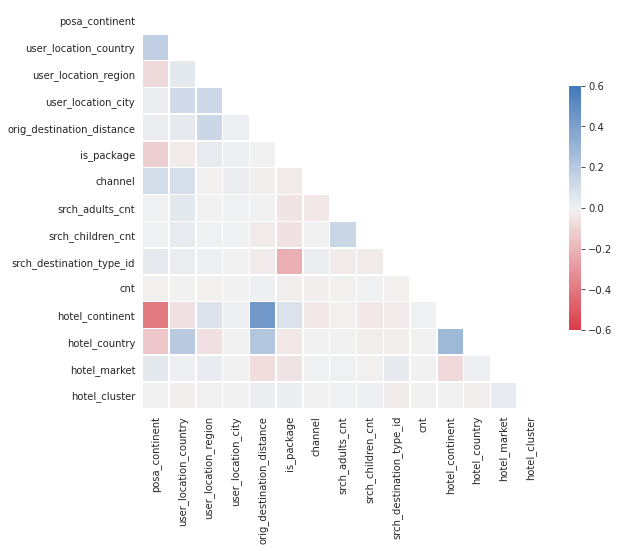

In [ ]:
# remove site_name, continent ID is likely similar to hotel_continent and is 
# more important as shown by xgboost below
df.drop(columns=['site_name', 'srch_rm_cnt', 'user_id', 'srch_destination_id', 
                 'is_mobile'], inplace=True)
df = df[df['is_booking'] == 1].drop(columns=['is_booking'])
plot_corr(df)

TODO talk about random forest feature importance from the end of the file.

Additionally, we observe that in their current representation the datetime values are not of much use, and we should consider other embeddings. One such embedding that would better help capture the season, and thus arguably the type of hotel and destination, would be to transform the date-time into its integer month. In a similar fashion, the search_ci and search_co values, checking and checkout dates, are linked and can be merged into a single value indicating the duration of the stay, which can be better compared with other users' bookings. In order to not lose information about the date the user is looking to book the hotel, we ought to also add a field indicating the time between the current search and the checkin date.
Another heuristic is that the weekdays in which the search, and the booking, are made can give information about the purpose of the trip. Business trips will likely last less, be booked for different weekdays, and consider different hotels than say a summer family vacation. Perhaps some of these intuitions will be proven wrong, but we could verify this later again when considering correlation heatmaps or feature importance estimated by random forests.

In [ ]:
df['srch_duration'] = (df['srch_co'] - df['srch_ci']).dt.days
df['days_bef_ci'] = (df['srch_ci'] - df['date_time']).dt.days
df['srch_month'] = df['date_time'].dt.month
df['srch_weekday'] = df['date_time'].dt.weekday
df['srch_ci_weekday'] = df['srch_ci'].dt.weekday
df['srch_co_weekday'] = df['srch_co'].dt.weekday
df.drop(columns=['date_time', 'srch_co', 'srch_ci'], inplace=True)

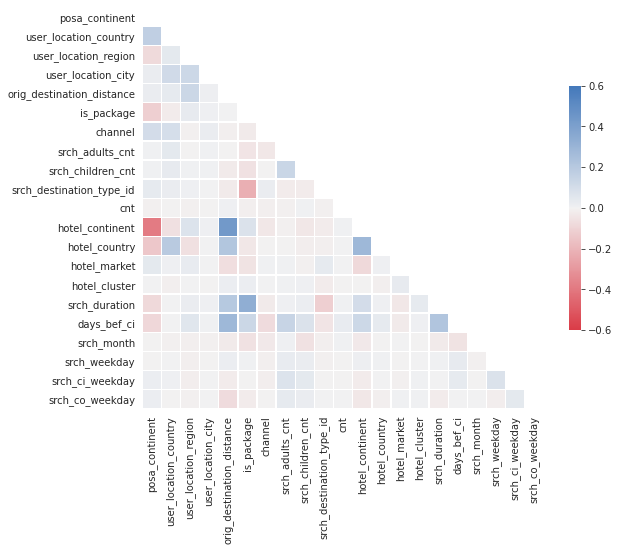

In [ ]:
plot_corr(df)

## Data Visualisation

<AxesSubplot:xlabel='days_bef_ci', ylabel='count'>

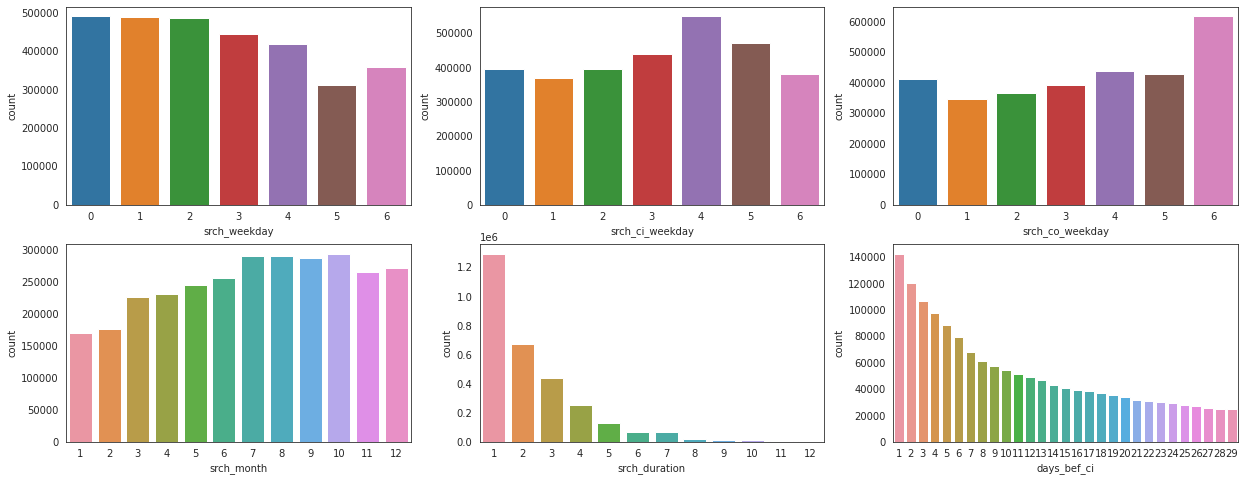

In [ ]:
%%capture --no-display
fig, axs = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(21, 8)
sb.countplot('srch_weekday', data=df, order=list(range(0, 7)), ax=axs[0,0])
sb.countplot('srch_ci_weekday', data=df, order=list(range(0, 7)), ax=axs[0,1])
sb.countplot('srch_co_weekday', data=df, order=list(range(0, 7)), ax=axs[0,2])
sb.countplot('srch_month', data=df, order=list(range(1,13)), ax=axs[1,0])
sb.countplot('srch_duration', data=df, order=list(range(1,13)), ax=axs[1,1])
sb.countplot('days_bef_ci', data=df, order=list(range(1,30)), ax=axs[1,2])

<AxesSubplot:xlabel='days_bef_ci', ylabel='count'>

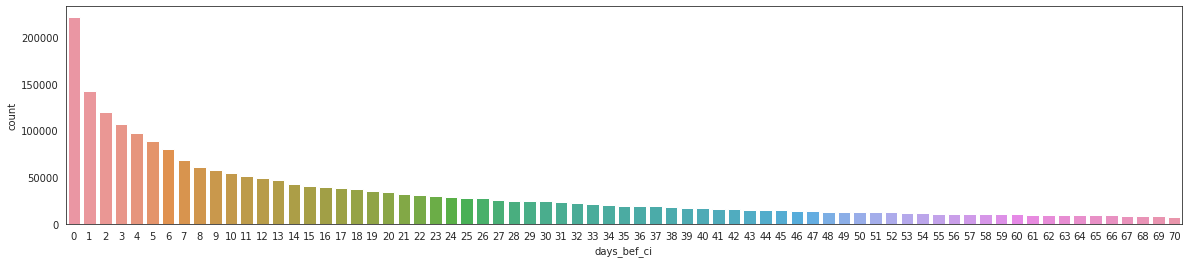

In [ ]:
%%capture --no-display
fig, ax = plt.subplots()
fig.set_size_inches(20, 4)
sb.countplot('days_bef_ci', data=df, order=list(range(0, 71)), ax=ax)

## Imputation

In [ ]:
try:
  print(df.isnull().sum())
except NameError:
  pass

date_time                           0
site_name                           0
posa_continent                      0
user_location_country               0
user_location_region                0
user_location_city                  0
orig_destination_distance    13525001
user_id                             0
is_mobile                           0
is_package                          0
channel                             0
srch_ci                             0
srch_co                             0
srch_adults_cnt                     0
srch_children_cnt                   0
srch_rm_cnt                         0
srch_destination_id                 0
srch_destination_type_id            0
is_booking                          0
cnt                                 0
hotel_continent                     0
hotel_country                       0
hotel_market                        0
hotel_cluster                       0
dtype: int64


As mentioned in the report, the expedia competition faced an issue with data leakage that significantly boosted previous submissions accuracy by +.10 to .20 which, considering that the top10 submissions only average around .53 accuracy, is a tremendous advantage. We do not use this data leak, but based on feature importance from random forest runs, we observed that location is the single-most important feature in predicting hotel_cluster. We can therefore try to impute the orig_destination_distance which is missing the most entries of all the columns.

In [ ]:
# note: returns an ndarray object
def impute_data(data, iterative=True, strat='mean'): # 'most_frequent'
  imp = IterativeImputer(missing_values=np.nan) if iterative else SimpleImputer(missing_values=np.nan, strategy=strat)
  return imp.fit_transform(data)

## Data Processing

Summing up our previous feature selection process, we can define and use the following functions.

In [ ]:
def filter_data(df):
  df.drop(columns=['site_name', 'srch_rm_cnt', 'user_id', 'srch_destination_id', 
                  'is_mobile'], inplace=True)
  if 'is_booking' in list(df.columns):
    df = df[df['is_booking'] == 1].drop(columns=['is_booking'])
  df['srch_duration'] = (df['srch_co'] - df['srch_ci']).dt.days
  df['days_bef_ci'] = (df['srch_ci'] - df['date_time']).dt.days
  df['srch_month'] = df['date_time'].dt.month
  df['srch_weekday'] = df['date_time'].dt.weekday
  df['srch_ci_weekday'] = df['srch_ci'].dt.weekday
  df['srch_co_weekday'] = df['srch_co'].dt.weekday
  df.drop(columns=['date_time', 'srch_co', 'srch_ci'], inplace=True)
  return df

In [ ]:
# (optional) join the raw data with destination dataset on srch_destination_id column
# data_raw = data_raw.merge(destinations_raw, how = "left", on = "srch_destination_id")

In [ ]:
%%time
data = load_data(percentage=p) # leaky_load(120000)
data = filter_data(data)

labels = data["hotel_cluster"].to_numpy()
data.drop(columns=['hotel_cluster'], inplace=True)
feature_names = data.columns.to_list() # for graphing

data = impute_data(data)

CPU times: user 11min 1s, sys: 13min 58s, total: 25min
Wall time: 2min 28s


In [ ]:
# split train/validation and test dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    random_state = rstate,
                                                    test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    random_state = rstate,
                                                    test_size = 0.1)
print("Training data size: %d" %(len(y_train)))
print("Validation data size: %d" %(len(y_val)))
print("Test data size: %d" %(len(y_test)))

Training data size: 2160498
Validation data size: 240056
Test data size: 600139


In [ ]:
# standardize for mean and variance, set non-std to None if necessary
scaler = StandardScaler() 
scaler.fit(X_train)

X_std_train = scaler.transform(X_train)
X_std_val = scaler.transform(X_val)
X_std_test = scaler.transform(X_test)
# X_train, X_val, X_test = None, None, None

# Methods

## Generic Functions

In [ ]:
# converts probabilites ps to most likely classes
def to_preds(ps):
  return (-ps).argsort(axis=-1)

In [ ]:
# MAP@5 function
# input: list of probabilities (lists), list of actual values
def map5probs(actual, predicted_probabilities):
  predicted = to_preds(predicted_probabilities)
  return map5preds(actual, predicted)

# input: list of predictions (lists)
def map5preds(actual, predicted_ranks):
  actual = [[y] for y in actual]
  return mapk(actual, predicted_ranks[:, :5], 5)

In [ ]:
# sklearn-type scorer that can be used in GridSearchCV
def sk_map5(clf, X, y_true):
  ps = clf.predict_proba(X)
  return map5probs(y_true, ps)

In [ ]:
# xgb-type scorer used in xgb training
def xgb_map5(ps, dtrain):
    actual = dtrain.get_label()
    return 'MAP@5', -map5probs(actual, ps)

In [ ]:
# takes model capable of predicting probabilities, trains it, and runs acc_stats 
def acc(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    return acc_stats(clf, X_test, y_test)

# returns map5 acc. as well as rank stats for predictions
def acc_stats(clf, X_test, y_test):
  ps = clf.predict_proba(X_test)
  preds = to_preds(ps)
  return pred_stats(preds, y_test)

# takes in a list of predictions (100 elts each)
def pred_stats(preds, y_test):
  ranks = [0]*100
  for i, (y, p) in enumerate(zip(y_test, preds.tolist())):
    ranks[p.index(y)] += 1

  return map5preds(y_test, preds), ranks

# computes both std stats as well as result from applying leak
def leaky_stats(clf, leaky_clf, X_test, y_test, X_test_leaky, replacements=2):
  ps = clf.predict_proba(X_test)
  preds = to_preds(ps)
  clf_stats = pred_stats(preds, y_test)

  l_preds = leaky_clf.predict(preds, X_test_leaky, replacements)
  l_stats = pred_stats(l_preds, y_test)
  return clf_stats, l_stats

# plots rank and map5 stats
def plot_acc_stats(stats):
  # plt.rcdefaults() # resets to pyplot defaults
  acc, ranks = stats
  fig, ax = plt.subplots()
  ax.bar(x=np.arange(len(ranks)), 
         height=np.array(ranks) * 100.0 / np.sum(ranks))
  
  plt.xlabel('suggestion rank')
  plt.ylabel('% test set')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.set_axisbelow(True)
  ax.yaxis.grid(True, color='#DDDDDD')

  ax.set_title('rank of true y in suggestions\n map@5: %.4f' %(acc))
  plt.show()

# writes list of predictions to file for Kaggle submission
def make_submission(preds):
  now = datetime.datetime.now()
  fn = 'submission_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
  out = open(fn, "w")
  i = 0
  out.write("id,hotel_cluster\n")
  for pred in tqdm(preds, total=len(preds)):
    out.write(str(i) + ',')
    for p in pred[:5]:
      out.write(' ' + str(p))
    out.write('\n')
    i += 1
  out.close()

In [ ]:
# prints results of a GridSearchCV fit. Code from sklearn tutorial
def print_gridCV(clf):
  print("Grid scores on development set:\n")
  means = clf.cv_results_['mean_test_score']
  stds = clf.cv_results_['std_test_score']
  for mean, std, params in zip(means, stds, clf.cv_results_['params']):
      print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))
  print()

In [ ]:
# Gradient Boosting Tree classifier pre-trained on 70-10-20 train-val-test split of full train.csv
def load_gbt(filename='gbt.model'):
  gbt = XGBClassifier(objective = 'multi:softmax',
                      tree_method = 'hist', #'gpu_hist' if gpu available
                      max_depth = 5, 
                      n_estimators=300,
                      n_jobs=-1,
                      #learning_rate=0.01, 
                      random_state=rstate,
                      min_child_weight = 3,
                      silent=False)

  gbt.load_model(root_path + filename)
  return gbt

## Baseline

In [ ]:
baseline = np.array([[90, 64, 40, 58, 82]] * len(y_test))
map5preds(y_test, baseline)

0.022692265070921987

## SVM

In [ ]:
%%time 
# SVM is computationally intractable for this problem, "more than quadratic in number of samples"
# according to sklearn docs. Linear SVMs such as LinearSVC or LinearSVR do not implement predict_proba 
# necessary for map5 computation

# clf = BaggingClassifier(base_estimator = SVC(), n_estimators = 20, n_jobs=-1, verbose=v)
# acc(clf, X_std_train, y_train, X_std_test, y_test)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.53 µs


## Logistic Regression

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.8min remaining: 10.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  6.8min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.9min finished


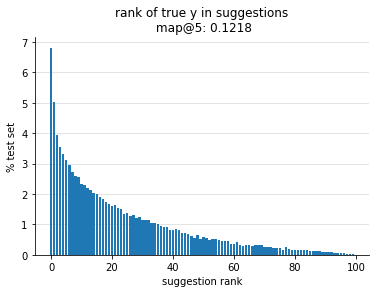

CPU times: user 1min 7s, sys: 1min 5s, total: 2min 13s
Wall time: 7min 10s


In [ ]:
%%time
# single logistic regressor
lg_CV = LogisticRegressionCV(random_state = rstate, max_iter=100, n_jobs=-1, verbose=v)
plot_acc_stats(acc(lg_CV, X_std_train, y_train, X_std_test, y_test))

In [ ]:
%%time
# Bagging
lg = LogisticRegression(random_state = rstate, max_iter=100, n_jobs = -1)
lg_bag = BaggingClassifier(base_estimator = SVC(), n_estimators = 20, n_jobs=-1, verbose=v)
plot_acc_stats(acc(lg_bag, X_std_train, y_train, X_std_test, y_test))

## KNN

In [ ]:
%%time
parameters = {'n_neighbors' : [2**i for i in range(8)]}
knn = KNeighborsClassifier(n_jobs = -1)
knn_srch = GridSearchCV(knn, parameters, scoring = sk_map5, n_jobs = -1, verbose=v)
plot_acc_stats(acc(knn_srch, X_std_train, y_train, X_std_test, y_test))

In [ ]:
print_gridCV(knn_srch)

CV using k = 1: 0.0766
CV using k = 2: 0.0845
CV using k = 4: 0.0924
CV using k = 8: 0.0949
CV using k = 16: 0.0994
CV using k = 32: 0.1096
CV using k = 64: 0.1166
CV using k = 128: 0.1220


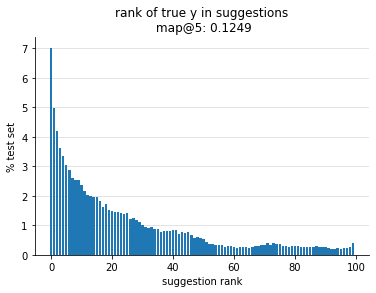

CPU times: user 11min 44s, sys: 0 ns, total: 11min 44s
Wall time: 11min 36s


In [ ]:
%%time
# wrapper for facebook's "faiss" knn implementation -- orders of magnitude faster than sklearn
faiss.omp_set_num_threads(faiss.omp_get_max_threads())
# print(acc(faiss_knn, X_std_train, y_train, X_std_test, y_test))
ns = [2**i for i in range(8)]
kf = KFold(5, shuffle=True, random_state = rstate)
best_k = 0
best_cv = 0
for k in ns:
  fold_scores = []
  for train_idx, val_idx in kf.split(X_std_train):
    clf = FaissKNNClassifier(n_neighbors=k, n_jobs = -1)
    score, _ = acc(clf, X_std_train[train_idx], y_train[train_idx], 
                           X_std_train[val_idx], y_train[val_idx])
    fold_scores.append(score)
  cv = np.mean(fold_scores)
  if cv > best_cv:
    best_cv = cv
    best_k = k
  print('CV using k = %d: %.4f' %(k, cv))
  
plot_acc_stats(acc(FaissKNNClassifier(n_neighbors=best_k, n_jobs=-1), 
                   X_std_train, y_train, X_std_test, y_test))

## Naive Bayes

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Accuracy: 0.09 (+/- 0.00)


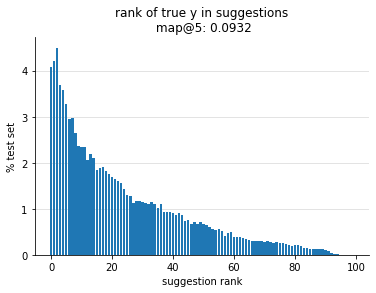

CPU times: user 1.25 s, sys: 0 ns, total: 1.25 s
Wall time: 2.91 s


In [ ]:
%%time
gauss_score = cross_val_score(GaussianNB(), X_std_train, y_train, 
                              scoring = sk_map5, 
                              n_jobs = -1, verbose=v)
print("Accuracy: %0.2f (+/- %0.2f)" % (gauss_score.mean(), gauss_score.std() * 2))
plot_acc_stats(acc(GaussianNB(), X_std_train, y_train, X_std_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Accuracy: 0.12 (+/- 0.00)


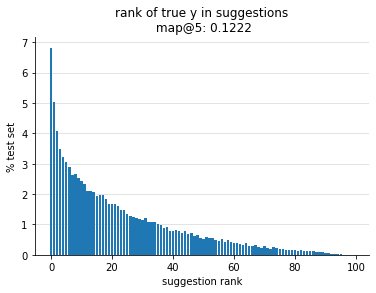

CPU times: user 1.91 s, sys: 2.1 s, total: 4.01 s
Wall time: 2.18 s


In [ ]:
%%time
bernoulli_score = cross_val_score(BernoulliNB(), X_std_train, y_train, 
                                  scoring = sk_map5, 
                                  n_jobs = -1, verbose=v)
print("Accuracy: %0.2f (+/- %0.2f)" % (bernoulli_score.mean(), bernoulli_score.std() * 2))
plot_acc_stats(acc(BernoulliNB(), X_std_train, y_train, X_std_test, y_test))

## Random Forest

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_estimators=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... n_estimators=1, score=0.088, total=   3.1s
[CV] n_estimators=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] ...................... n_estimators=1, score=0.083, total=   1.4s
[CV] n_estimators=1 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV] ...................... n_estimators=1, score=0.078, total=   1.3s
[CV] n_estimators=1 ..................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s


[CV] ...................... n_estimators=1, score=0.087, total=   1.3s
[CV] n_estimators=1 ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.1s remaining:    0.0s


[CV] ...................... n_estimators=1, score=0.077, total=   1.3s
[CV] n_estimators=5 ..................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.4s remaining:    0.0s


[CV] ...................... n_estimators=5, score=0.158, total=   2.5s
[CV] n_estimators=5 ..................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   11.0s remaining:    0.0s


[CV] ...................... n_estimators=5, score=0.154, total=   2.5s
[CV] n_estimators=5 ..................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   13.5s remaining:    0.0s


[CV] ...................... n_estimators=5, score=0.148, total=   2.5s
[CV] n_estimators=5 ..................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   16.0s remaining:    0.0s


[CV] ...................... n_estimators=5, score=0.156, total=   2.3s
[CV] n_estimators=5 ..................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   18.4s remaining:    0.0s


[CV] ...................... n_estimators=5, score=0.153, total=   2.3s
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.184, total=   3.9s
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.179, total=   3.9s
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.175, total=   3.9s
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.182, total=   4.1s
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.181, total=   4.0s
[CV] n_estimators=50 .................................................
[CV] ..................... n_estimators=50, score=0.240, total=  16.4s
[CV] n_estimators=50 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 10.5min finished


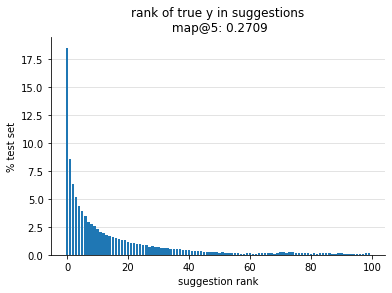

CPU times: user 9min 17s, sys: 7min 13s, total: 16min 30s
Wall time: 11min 55s


In [ ]:
%%time
parameters = {'n_estimators' : [1,5,10,50,100,200]}
rf = RandomForestClassifier(n_jobs=-1, random_state = rstate)
rf_srch = GridSearchCV(rf, parameters, scoring = sk_map5, verbose=v)
plot_acc_stats(acc(rf_srch, X_std_train, y_train, X_std_test, y_test))

In [ ]:
print_gridCV(rf_srch)

Grid scores on development set:

0.082 (+/-0.009) for {'n_estimators': 1}
0.154 (+/-0.007) for {'n_estimators': 5}
0.180 (+/-0.006) for {'n_estimators': 10}
0.238 (+/-0.005) for {'n_estimators': 50}
0.251 (+/-0.005) for {'n_estimators': 100}
0.258 (+/-0.005) for {'n_estimators': 200}



In [ ]:
# TODO weirdly... not training
# xgb_rf = XGBRFClassifier(objective = 'multi:softmax',
#                         tree_method = 'hist', #'gpu_hist' if gpu available
#                         n_estimators=100,
#                         n_jobs=-1,
#                         #learning_rate=0.01,
#                         min_child_weight = 3,
#                         random_state = rstate,
#                         silent=False)

# xgb_rf.fit(X_train, y_train, 
#         early_stopping_rounds=20, 
#         eval_metric=xgb_map5, 
#         eval_set=[(X_train, y_train), (X_val, y_val)])
# xgb_rf.get_booster().feature_names = feature_names

## AdaBoost

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:  2.0min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  35 out of  60 | elapsed:  2.9min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  42 out of  60 | elapsed:  6.2min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  49 out of  60 | elapsed:  8.0min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  56 out of  60 | elapsed: 10.3min remaining:   43.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.5min finished


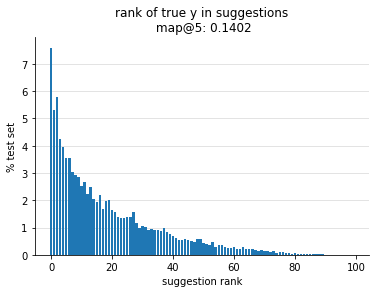

CPU times: user 5.98 s, sys: 0 ns, total: 5.98 s
Wall time: 10min 34s


In [ ]:
%%time
parameters = {'base_estimator' : [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)],
             'n_estimators' : [1,5,10,50,100,150]}
adb = AdaBoostClassifier(learning_rate = 0.1, random_state=rstate)
adb_srch = GridSearchCV(adb, parameters, scoring = sk_map5, n_jobs = -1, verbose = v)
plot_acc_stats(acc(adb_srch, X_std_train, y_train, X_std_test, y_test))

In [ ]:
print_gridCV(adb_srch)

Grid scores on development set:

0.104 (+/-0.001) for {'base_estimator': DecisionTreeClassifier(max_depth=1), 'n_estimators': 1}
0.104 (+/-0.001) for {'base_estimator': DecisionTreeClassifier(max_depth=1), 'n_estimators': 5}
0.104 (+/-0.001) for {'base_estimator': DecisionTreeClassifier(max_depth=1), 'n_estimators': 10}
0.113 (+/-0.003) for {'base_estimator': DecisionTreeClassifier(max_depth=1), 'n_estimators': 50}
0.123 (+/-0.001) for {'base_estimator': DecisionTreeClassifier(max_depth=1), 'n_estimators': 100}
0.125 (+/-0.007) for {'base_estimator': DecisionTreeClassifier(max_depth=1), 'n_estimators': 150}
0.137 (+/-0.001) for {'base_estimator': DecisionTreeClassifier(max_depth=3), 'n_estimators': 1}
0.140 (+/-0.003) for {'base_estimator': DecisionTreeClassifier(max_depth=3), 'n_estimators': 5}
0.135 (+/-0.001) for {'base_estimator': DecisionTreeClassifier(max_depth=3), 'n_estimators': 10}
0.134 (+/-0.004) for {'base_estimator': DecisionTreeClassifier(max_depth=3), 'n_estimators': 50}

## Gradient Tree Boosting

[19:56:59] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-merror:0.88198	validation_1-merror:0.88846	validation_0-MAP@5:-0.20284	validation_1-MAP@5:-0.19224
Multiple eval metrics have been passed: 'validation_1-MAP@5' will be used for early stopping.

Will train until validation_1-MAP@5 hasn't improved in 20 rounds.
[1]	validation_0-merror:0.87412	validation_1-merror:0.88085	validation_0-MAP@5:-0.21546	validation_1-MAP@5:-0.20289
[2]	validation_0-merror:0.87086	validation_1-merror:0.87882	validation_0-MAP@5:-0.22126	validation_1-MAP@5:-0.20699
[3]	validation_0-merror:0.86818	validation_1-merror:0.87832	validation_0-MAP@5:-0.22531	validation_1-MAP@5:-0.20882
[4]	validation_0-merror:0.86611	validation_1-merr

[66]	validation_0-merror:0.76345	validation_1-merror:0.85883	validation_0-MAP@5:-0.35313	validation_1-MAP@5:-0.24002
[67]	validation_0-merror:0.76172	validation_1-merror:0.85862	validation_0-MAP@5:-0.35507	validation_1-MAP@5:-0.24022
[68]	validation_0-merror:0.75979	validation_1-merror:0.85771	validation_0-MAP@5:-0.35692	validation_1-MAP@5:-0.24111
[69]	validation_0-merror:0.75817	validation_1-merror:0.85758	validation_0-MAP@5:-0.35876	validation_1-MAP@5:-0.24133
[70]	validation_0-merror:0.75669	validation_1-merror:0.85750	validation_0-MAP@5:-0.36042	validation_1-MAP@5:-0.24138
[71]	validation_0-merror:0.75499	validation_1-merror:0.85767	validation_0-MAP@5:-0.36204	validation_1-MAP@5:-0.24137
[72]	validation_0-merror:0.75327	validation_1-merror:0.85721	validation_0-MAP@5:-0.36393	validation_1-MAP@5:-0.24165
[73]	validation_0-merror:0.75159	validation_1-merror:0.85717	validation_0-MAP@5:-0.36557	validation_1-MAP@5:-0.24182
[74]	validation_0-merror:0.75033	validation_1-merror:0.85721	val

[136]	validation_0-merror:0.65300	validation_1-merror:0.85031	validation_0-MAP@5:-0.46543	validation_1-MAP@5:-0.24868
[137]	validation_0-merror:0.65138	validation_1-merror:0.84998	validation_0-MAP@5:-0.46703	validation_1-MAP@5:-0.24872
[138]	validation_0-merror:0.64998	validation_1-merror:0.85014	validation_0-MAP@5:-0.46845	validation_1-MAP@5:-0.24857
[139]	validation_0-merror:0.64847	validation_1-merror:0.85056	validation_0-MAP@5:-0.47001	validation_1-MAP@5:-0.24830
[140]	validation_0-merror:0.64699	validation_1-merror:0.85068	validation_0-MAP@5:-0.47142	validation_1-MAP@5:-0.24831
[141]	validation_0-merror:0.64531	validation_1-merror:0.85060	validation_0-MAP@5:-0.47295	validation_1-MAP@5:-0.24854
[142]	validation_0-merror:0.64377	validation_1-merror:0.85077	validation_0-MAP@5:-0.47437	validation_1-MAP@5:-0.24851
[143]	validation_0-merror:0.64227	validation_1-merror:0.85064	validation_0-MAP@5:-0.47585	validation_1-MAP@5:-0.24853
[144]	validation_0-merror:0.64097	validation_1-merror:0.

[206]	validation_0-merror:0.55827	validation_1-merror:0.84487	validation_0-MAP@5:-0.55537	validation_1-MAP@5:-0.25241
[207]	validation_0-merror:0.55701	validation_1-merror:0.84520	validation_0-MAP@5:-0.55665	validation_1-MAP@5:-0.25223
[208]	validation_0-merror:0.55584	validation_1-merror:0.84549	validation_0-MAP@5:-0.55781	validation_1-MAP@5:-0.25220
[209]	validation_0-merror:0.55442	validation_1-merror:0.84520	validation_0-MAP@5:-0.55910	validation_1-MAP@5:-0.25234
[210]	validation_0-merror:0.55317	validation_1-merror:0.84457	validation_0-MAP@5:-0.56015	validation_1-MAP@5:-0.25258
[211]	validation_0-merror:0.55218	validation_1-merror:0.84491	validation_0-MAP@5:-0.56109	validation_1-MAP@5:-0.25253
[212]	validation_0-merror:0.55107	validation_1-merror:0.84528	validation_0-MAP@5:-0.56216	validation_1-MAP@5:-0.25224
[213]	validation_0-merror:0.54976	validation_1-merror:0.84574	validation_0-MAP@5:-0.56334	validation_1-MAP@5:-0.25195
[214]	validation_0-merror:0.54839	validation_1-merror:0.

[276]	validation_0-merror:0.47710	validation_1-merror:0.84167	validation_0-MAP@5:-0.62890	validation_1-MAP@5:-0.25469
[277]	validation_0-merror:0.47605	validation_1-merror:0.84196	validation_0-MAP@5:-0.62981	validation_1-MAP@5:-0.25442
[278]	validation_0-merror:0.47506	validation_1-merror:0.84191	validation_0-MAP@5:-0.63074	validation_1-MAP@5:-0.25457
[279]	validation_0-merror:0.47392	validation_1-merror:0.84183	validation_0-MAP@5:-0.63178	validation_1-MAP@5:-0.25463
[280]	validation_0-merror:0.47294	validation_1-merror:0.84142	validation_0-MAP@5:-0.63267	validation_1-MAP@5:-0.25476
[281]	validation_0-merror:0.47189	validation_1-merror:0.84142	validation_0-MAP@5:-0.63355	validation_1-MAP@5:-0.25477
[282]	validation_0-merror:0.47086	validation_1-merror:0.84150	validation_0-MAP@5:-0.63447	validation_1-MAP@5:-0.25466
[283]	validation_0-merror:0.46987	validation_1-merror:0.84121	validation_0-MAP@5:-0.63542	validation_1-MAP@5:-0.25485
[284]	validation_0-merror:0.46872	validation_1-merror:0.

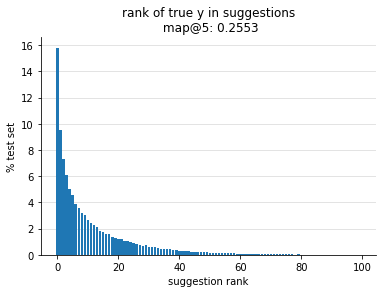

CPU times: user 46min 48s, sys: 0 ns, total: 46min 48s
Wall time: 46min 43s


In [ ]:
%%time
gbt = XGBClassifier(objective = 'multi:softmax',
                        tree_method = 'hist', #'gpu_hist' if gpu available
                        max_depth = 5, 
                        n_estimators=300,
                        n_jobs=-1,
                        #learning_rate=0.01, 
                        random_state=rstate,
                        min_child_weight = 3,
                        silent=False)

gbt.fit(X_train, y_train, 
        early_stopping_rounds=20, 
        eval_metric=xgb_map5, 
        eval_set=[(X_train, y_train), (X_val, y_val)])

plot_acc_stats(acc_stats(gbt, X_test=X_test, y_test=y_test))

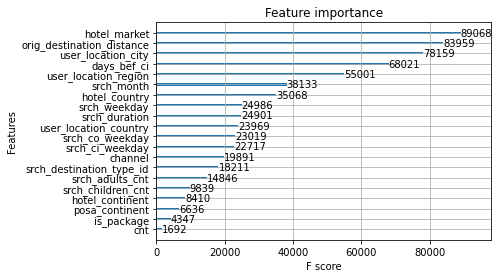

In [ ]:
#gbt.save_model('0001.model')
gbt.get_booster().feature_names = feature_names
xgb.plot_importance(gbt)
plt.show()

# Leakage


## Original

In [ ]:
%%time
# ORIGINAL FILE
import datetime
from heapq import nlargest
from operator import itemgetter
from collections import defaultdict

def run_solution():
  print('Preparing arrays...')
  f = open(root_path + "train.csv", "r")
  f.readline()
  best_hotels_od_ulc = defaultdict(lambda: defaultdict(int))
  best_hotels_search_dest = defaultdict(lambda: defaultdict(int))
  best_hotels_search_dest1 = defaultdict(lambda: defaultdict(int))
  best_hotel_country = defaultdict(lambda: defaultdict(int))
  popular_hotel_cluster = defaultdict(int)
  total = 0

  # Calc counts
  while 1:
    # could substitute this for a loop through the pandas dF rows
    line = f.readline().strip()
    total += 1

    if total % 10000000 == 0:
      print('Read {} lines...'.format(total))

    if line == '':
      break

    # Can be omitted if we view the data through a pandas dF
    arr = line.split(",")
    book_year = int(arr[0][:4])
    user_location_city = arr[5]
    orig_destination_distance = arr[6]
    srch_destination_id = arr[16]
    is_booking = int(arr[18])
    hotel_country = arr[21]
    hotel_market = arr[22]
    hotel_cluster = arr[23]

    # could add these to pandas dF. Could define these new cols outside of 
    # the loop 
    append_1 = 3 + 17*is_booking
    append_2 = 1 + 5*is_booking

    # this is the most important part of the data leak to take into account
    if user_location_city != '' and orig_destination_distance != '':
      best_hotels_od_ulc[(user_location_city, orig_destination_distance)][hotel_cluster] += 1

    # less important aspects and could be substituted for, say, classifier's predictions
    if srch_destination_id != '' and hotel_country != '' and hotel_market != '' and book_year == 2014:
      best_hotels_search_dest[(srch_destination_id, hotel_country, hotel_market)][hotel_cluster] += append_1
    
    # same story
    if srch_destination_id != '':
      best_hotels_search_dest1[srch_destination_id][hotel_cluster] += append_1
    
    # even less important
    if hotel_country != '':
      best_hotel_country[hotel_country][hotel_cluster] += append_2
    
    # skippp
    popular_hotel_cluster[hotel_cluster] += 1
  
  f.close()

  # File writing because Kaggle-submission oriented. Can substitute it with
  # a more dynamic approach, i.e. a function that only takes an entry each time,
  # equiv of a line here
  print('Generate submission...')
  now = datetime.datetime.now()
  path = 'submission_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
  out = open(path, "w")
  f = open(root_path + "test.csv", "r")
  f.readline()
  total = 0
  out.write("id,hotel_cluster\n")

  # most popular cluster hotels, used to fill in the top 5 choices. We can probably
  # ignore this in favor of our models
  topclasters = nlargest(5, sorted(popular_hotel_cluster.items()), key=itemgetter(1))

  while 1:
    line = f.readline().strip()
    total += 1

    if total % 1000000 == 0:
      print('Write {} lines...'.format(total))

    if line == '':
      break

    # we'll already know these attributes from our pandas/np setup
    arr = line.split(",")
    id = arr[0]
    user_location_city = arr[6]
    orig_destination_distance = arr[7]
    srch_destination_id = arr[17]
    hotel_country = arr[20]
    hotel_market = arr[21]

    out.write(str(id) + ',')
    # keeps track of the predictions made so far
    filled = []

    # checks for most important of the previous attributes
    s1 = (user_location_city, orig_destination_distance)
    if s1 in best_hotels_od_ulc:
      d = best_hotels_od_ulc[s1]
      topitems = nlargest(5, sorted(d.items()), key=itemgetter(1))
      for i in range(len(topitems)):
        if topitems[i][0] in filled:
          continue
        if len(filled) == 5:
          break
        # here it would be like "shift" the model's predictions by one and add
        # this heuristic's prediction
        out.write(' ' + topitems[i][0])
        filled.append(topitems[i][0])

    # similar process, but essentially "cases down" to lower priority predictions
    s2 = (srch_destination_id, hotel_country, hotel_market)
    if s2 in best_hotels_search_dest:
      d = best_hotels_search_dest[s2]
      topitems = nlargest(5, d.items(), key=itemgetter(1))
      for i in range(len(topitems)):
        if topitems[i][0] in filled:
          continue
        if len(filled) == 5:
          break
        out.write(' ' + topitems[i][0])
        filled.append(topitems[i][0])

    elif srch_destination_id in best_hotels_search_dest1:
      d = best_hotels_search_dest1[srch_destination_id]
      topitems = nlargest(5, d.items(), key=itemgetter(1))
      for i in range(len(topitems)):
        if topitems[i][0] in filled:
          continue
        if len(filled) == 5:
          break
        out.write(' ' + topitems[i][0])
        filled.append(topitems[i][0])

    if hotel_country in best_hotel_country:
      d = best_hotel_country[hotel_country]
      topitems = nlargest(5, d.items(), key=itemgetter(1))
      for i in range(len(topitems)):
        if topitems[i][0] in filled:
            continue
        if len(filled) == 5:
            break
        out.write(' ' + topitems[i][0])
        filled.append(topitems[i][0])

    for i in range(len(topclasters)):
      if topclasters[i][0] in filled:
        continue
      if len(filled) == 5:
        break
      out.write(' ' + topclasters[i][0])
      filled.append(topclasters[i][0])

    out.write("\n")
  out.close()
  print('Completed!')

# run_solution() # this will generate a submission file

CPU times: user 4 µs, sys: 6 µs, total: 10 µs
Wall time: 11.2 µs


## Adaptation

In [ ]:
# modifications
import datetime
from heapq import nlargest
from operator import itemgetter
from collections import defaultdict

# the panda dF "data" here contains all original training data, i.e. also labels
# terribly inefficient
class leaky():
  def __init__(self, data=None, read_all=False, filename='train.csv'):
    self.best_hotels_od_ulc = defaultdict(lambda: defaultdict(int))
    self.best_hotels_search_dest = defaultdict(lambda: defaultdict(int))
    if not data is None:
      self.fit(data)
    if read_all:
      self.fit_all(filename)
  
  def fit_all(self, filename):
    with tqdm(total = 37670294) as bar:
      f = open(root_path + filename, "r")
      f.readline()
      while 1:
        line = f.readline().strip()

        if line == '':
          break

        arr = line.split(",")
        book_year = int(arr[0][:4])
        user_location_city = arr[5]
        orig_destination_distance = arr[6]
        srch_destination_id = arr[16]
        is_booking = int(arr[18])
        hotel_country = arr[21]
        hotel_market = arr[22]
        hotel_cluster = arr[23]

        append_1 = 3 + 17*is_booking
        append_2 = 1 + 5*is_booking

        # this is the most important part of the data leak to take into account
        if user_location_city != '' and orig_destination_distance != '':
          self.best_hotels_od_ulc[(user_location_city, orig_destination_distance)][hotel_cluster] += 1

        # less important aspects and could be substituted for, say, classifier's predictions
        if srch_destination_id != '' and hotel_country != '' and hotel_market != '' and book_year == 2014:
          self.best_hotels_search_dest[(srch_destination_id, hotel_country, hotel_market)][hotel_cluster] += append_1
        bar.update(1)
    f.close()


  def fit(self, data):
    self.d = data.copy(deep=True)
    self.d['add'] = 3 + 17 * data['is_booking']
    with tqdm(total=len(self.d)) as bar:
      for _, r in self.d.iterrows():
        # this is the most important part of the data leak to take into account
        if not r[['user_location_city', 'orig_destination_distance']].isnull().any():
          self.best_hotels_od_ulc[(r['user_location_city'], 
                        r['orig_destination_distance'])][r['hotel_cluster']] += 1

        # less important aspects and could be substituted for, say, classifier's predictions
        if not r[['srch_destination_id', 'hotel_market', 'hotel_country']].isnull().any() and r['date_time'].year == 2014:
          self.best_hotels_search_dest[(r['srch_destination_id'], r['hotel_country'], 
                                      r['hotel_market'])][r['hotel_cluster']] += r['add']
        bar.update(1)
    
    
  # takes the predictions of a classifier for a testing set, and adjusts them
  def predict(self, preds, test, replacements=2):
    i = 0
    p = np.copy(preds)
    with tqdm(total = len(test)) as bar:
      for _, r in test.iterrows():
        added = []
        # checks for most important of the previous attributes
        s1 = (r['user_location_city'], r['orig_destination_distance'])
        if s1 in self.best_hotels_od_ulc:
          added = leaky.add_top_choices(self.best_hotels_od_ulc[s1], added)
        
        # similar process, but essentially "cases down" to lower priority predictions
        s2 = (r['srch_destination_id'], r['hotel_country'], r['hotel_market'])
        if s2 in self.best_hotels_search_dest:
          added = leaky.add_top_choices(self.best_hotels_search_dest[s2], added)
        p[i] = leaky.update_preds(added[:replacements], p[i])
        i += 1
        bar.update(1)
    return p
  
  def predict_all(self, preds, filename='test.csv', replacements=2):
    p = np.copy(preds)
    f = open(root_path + filename, "r")
    f.readline()
    with tqdm(total = 2528244) as bar:
      i = 0
      while 1:
        line = f.readline().strip()

        if line == '':
          break

        arr = line.split(",")
        id = arr[0]
        user_location_city = arr[6]
        orig_destination_distance = arr[7]
        srch_destination_id = arr[17]
        hotel_country = arr[20]
        hotel_market = arr[21]

        added = []

        s1 = (user_location_city, orig_destination_distance)
        if s1 in self.best_hotels_od_ulc:
          added = leaky.add_top_choices(self.best_hotels_od_ulc[s1], added)

        s2 = (srch_destination_id, hotel_country, hotel_market)
        if s2 in self.best_hotels_search_dest:
          added = leaky.add_top_choices(self.best_hotels_search_dest[s2], added)
        p[i] = leaky.update_preds(added[:replacements], p[i])
        i += 1
        bar.update(1)
    f.close
    return p


  # adds predictions x to front of list
  @staticmethod
  def update_preds(x, p):
    for el in x:
      p = np.delete(p, np.where(p == int(el)))
    return np.concatenate((x, p))

  # helper for leaky_clf
  @staticmethod
  def add_top_choices(d, added):
    top = nlargest(5, d.items(), key=itemgetter(1))
    for item in top:
      if item[0] not in added:
        added.append(item[0])
    return added


In [ ]:
def run_leaky_example(load_ps, percentage=0.01, users=12000):
    data = load_data(percentage=percentage) if load_ps else leaky_load(users)
    
    # split first so pandas object gets preserved, and we can further split into leaky/non_leaky
    # don't care about y's right now, still attach to the X's as separation is tricky for leaky implementation
    X_train_leaky, X_test_leaky, y, _ = train_test_split(data, data['hotel_cluster'],
                                             random_state = rstate,
                                             test_size = 0.2)
    X_train_leaky, X_val_leaky, _, _ = train_test_split(X_train_leaky, y, 
                                            random_state = rstate,
                                            test_size = 0.1)
    print("Before filtering:")
    print("Training data size: %d" %(len(X_train_leaky)))
    print("Validation data size: %d" %(len(X_val_leaky)))
    print("Test data size: %d" %(len(X_test_leaky)))
    print('Leaky Processing...')
    # only keept the bookings for test and validation
    X_val_leaky = X_val_leaky[X_val_leaky['is_booking'] == 1]
    X_test_leaky = X_test_leaky[X_test_leaky['is_booking'] == 1]
    leaky_clf = leaky(X_train_leaky)

    # now convert some of the data to numpy model training data
    # y_train, y_val, y_test = y_train.to_numpy(), y_val.to_numpy(), y_test.to_numpy()
    # filter and add features

    # extract and remove y's from validation and testing
    y_val, y_test = X_val_leaky['hotel_cluster'].to_numpy(), X_test_leaky['hotel_cluster'].to_numpy()
    X_val_leaky.drop(columns=['hotel_cluster'], inplace=True)
    X_test_leaky.drop(columns=['hotel_cluster'], inplace=True)


    X_train = X_train_leaky.copy(deep=True)
    X_val = X_val_leaky.copy(deep=True)
    X_test = X_test_leaky.copy(deep=True)

    X_train = filter_data(X_train)
    X_val, X_test = filter_data(X_val), filter_data(X_test)
    y_train = X_train['hotel_cluster'].to_numpy()
    X_train.drop(columns=['hotel_cluster'], inplace=True)
    print("Leaky Training data size: %d" %(len(X_train_leaky)))
    print("Model Training data size: %d" %(len(X_train)))
    print("Model Validation data size: %d" %(len(X_val)))
    print("Model Test data size: %d" %(len(X_test)))
    print('Predicting...')
    
    # impute
    imp = IterativeImputer(missing_values=np.nan)
    imp.fit(X_train)
    X_train, X_val, X_test = imp.transform(X_train), imp.transform(X_val), imp.transform(X_test)
    
    # simple example of a not-so performing model and how leaky would affect it
    bernNB = BernoulliNB()
    bernNB.fit(X_train, y_train)
    stats, lk5 = leaky_stats(bernNB, leaky_clf, X_test, y_test, X_test_leaky, replacements=5)
    print('Bernouilli Performance')
    plot_acc_stats(stats)
    print('Bernouilli Performance with at most 5 leaky replacements')
    plot_acc_stats(lk5)


[*] Running on all data associated with selected user_ids


  0%|          | 0/270126 [00:00<?, ?it/s]

Before filtering:
Training data size: 270126
Validation data size: 30014
Test data size: 75035
Leaky Processing...


100%|██████████| 270126/270126 [03:03<00:00, 1472.56it/s]


Leaky Training data size: 270126
Model Training data size: 22302
Model Validation data size: 2484
Model Test data size: 6238
Predicting...


100%|██████████| 6238/6238 [00:00<00:00, 7275.54it/s]


Bernouilli Performance


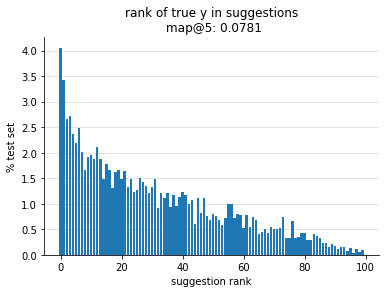

Bernouilli Performance with at most 5 leaky replacements


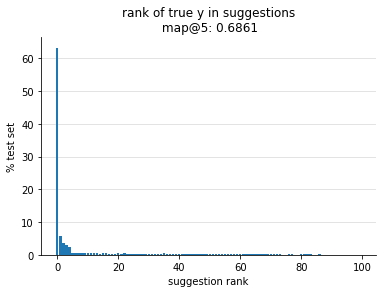


[*] Runnning on random subsection of data


  0%|          | 0/271994 [00:00<?, ?it/s]

Before filtering:
Training data size: 271994
Validation data size: 30222
Test data size: 75554
Leaky Processing...


100%|██████████| 271994/271994 [03:05<00:00, 1469.92it/s]


Leaky Training data size: 271994
Model Training data size: 21504
Model Validation data size: 2458
Model Test data size: 6118
Predicting...


100%|██████████| 6118/6118 [00:00<00:00, 7476.89it/s]


Bernouilli Performance


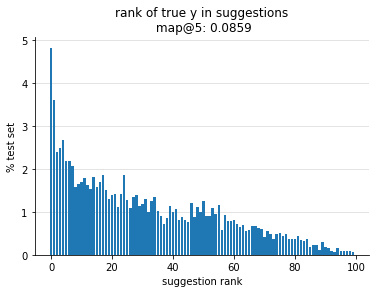

Bernouilli Performance with at most 5 leaky replacements


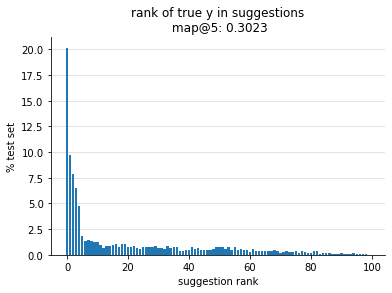

CPU times: user 7min 11s, sys: 38.3 s, total: 7min 49s
Wall time: 7min 9s


In [ ]:
%%time
# Running On Users only
print('\n[*] Running on all data associated with selected user_ids')
run_leaky_example(False)
# Running On Data Percentages only -- significant leaky performance drop, not so much for Bernouilli
print('\n[*] Runnning on random subsection of data')
run_leaky_example(True)

# Full Test Set predictions

In [ ]:
%%time
# load train sets
X_data = load_data(percentage=1)
X_data = filter_data(X_data)
labels = X_data["hotel_cluster"].to_numpy()
X_data.drop(columns=['hotel_cluster'], inplace=True)
feature_names = X_data.columns.to_list() # for graphing
X_data = impute_data(X_data)

CPU times: user 12min 5s, sys: 15min, total: 27min 6s
Wall time: 2min 32s


In [ ]:
# split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_data, labels,
                                                  random_state = rstate,
                                                  test_size = 0.1)
print("Training data size: %d" %(len(y_train)))
print("Validation data size: %d" %(len(y_val)))

Training data size: 2700623
Validation data size: 300070


In [ ]:
%%time
# load testing set/file
X_test = load_data(percentage=1, filename='test.csv')
X_test = filter_data(X_test)

X_test = impute_data(X_test)
print('Testing data size: %d' %(len(X_test)))

CPU times: user 10min 2s, sys: 12min 48s, total: 22min 51s
Wall time: 1min 35s


In [ ]:
# scale data for scale-variant methods
scaler = StandardScaler()
scaler.fit(X_train)

X_std_train = scaler.transform(X_train)
X_std_val = scaler.transform(X_val)
X_std_test = scaler.transform(X_test)

In [ ]:
# load leaky wrapper
lk = leaky(read_all=True)

100%|█████████▉| 37670293/37670294 [01:11<00:00, 528921.12it/s]


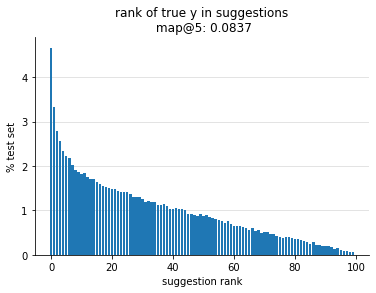

In [ ]:
# fit a model of choice. Bernouilli for speed/memory convenience
bernNB = BernoulliNB()
bernNB.fit(X_train, y_train)
plot_acc_stats(acc_stats(bernNB, X_val, y_val))

In [ ]:
# compute test set predictions
ps = bernNB.predict_proba(X_test)
preds = to_preds(ps)

In [ ]:
# submit
make_submission(preds)

100%|██████████| 2528243/2528243 [00:08<00:00, 298197.62it/s]


In [ ]:
# run leaky wrapper and make new submission file
make_submission(lk.predict_all(preds, replacements=2))

100%|██████████| 2528243/2528243 [00:08<00:00, 300109.43it/s]


In [ ]:
# load pretrained model
gbt = load_gbt()

In [ ]:
%%time
# compute xgboost predictions
ps = gbt.predict_proba(X_test)
preds = to_preds(ps)

CPU times: user 4h 52min 16s, sys: 484 ms, total: 4h 52min 16s
Wall time: 4h 52min 17s


In [ ]:
# submit
make_submission(preds)

100%|██████████| 2528243/2528243 [00:08<00:00, 301321.36it/s]


In [ ]:
# submit with leaky wrapper
make_submission(lk.predict_all(preds, replacements=2))

100%|█████████▉| 2528243/2528244 [04:50<00:00, 8697.44it/s]
